# Зависимости

In [2]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline

from mycsv import split_file
from dataset import load_data
from transform import Converter, to_same_length, vectorize_sequences

# Загрузка и конвертация данных

Разделение датасета на тренировочную выборку и тестовую

In [3]:
split_file('dataset.csv', split_ratio=0.8)

После разделения датасета в дериктории появиться два файла (тренировочный сет и тестовый).

* `maxlen` задает максимальную длину последовательности узлов функции (средняя длина последовательности ~50)

* `v` (verbose) задает многословность функций обработчиков (то столько будет выводится информации во время обратоки); доступные значения от 0 до 3

In [37]:
# Названия файлов
train_file_name = 'train_dataset.csv'
test_file_name = 'test_dataset.csv'
# Максимальная длина последовательности
maxlen = 200
# Вывод информации о данных
v = 3

Загрузка и трансформация данных для обучения

In [38]:
# Загрузка данных
x_train, y_train, x_test, y_test = load_data(
    train_file_name, 
    test_file_name, 
    verbose=v*3)
# Инициализация конвертеров
data_converter, marks_converter = Converter.build_converters(
    x_train, x_test, 
    y_train, y_test, verbose=v)
# Конвертация токенов в цифровой формат
x_train = data_converter.data_to_digital(x_train, verbose=v)
y_train = marks_converter.data_to_digital(y_train, verbose=v)
x_test = data_converter.data_to_digital(x_test, verbose=v)
y_test = marks_converter.data_to_digital(y_test, verbose=v)
# Приведение примеров к одной длине
x_train = to_same_length(x_train, maxlen, reverse=False, verbose=v)
x_test = to_same_length(x_test, maxlen, reverse=False, verbose=v)
# Кодирование классов в One Hot Encoded
y_train = vectorize_sequences(y_train, len(marks_converter), verbose=v)
y_test = vectorize_sequences(y_test, len(marks_converter), verbose=v)

Примеров в обучающей выбоке:132588
Примеров в тестовой выбоке:33075

Пример данных обучающей выборки:
arguments,args,self,timeout,defaults,none,body,TryExcept,body,Return,Call,AttributeLoad,AttributeLoad,self,attr,get,timeout,timeout,handlers,ExceptHandler,type,AttributeLoad,AttributeLoad,gevent,queue,empty,body,Raise,Call,NameLoad,timeout
Пример метки обучающей выборки:
call

Пример данных тестовой выборки:
arguments,args,self,defaults,body,If,Call,hasattr,self,Str,body,Assign,SubscriptStore,AttributeLoad,os,environ,Index,editor,AttributeLoad,self,attr,orelse,Delete,SubscriptDel,AttributeLoad,os,environ,Index,editor,Assign,AttributeStore,self,plugin,none,Assign,AttributeStore,self,env,none,Expr,Call,AttributeLoad,AttributeLoad,registration,attr,clear,Expr,Call,AttributeLoad,AttributeLoad,registration,attr,clear,Expr,Call,AttributeLoad,Call,super,NameLoad,self,teardown
Пример метки обучающей выборки:
teardown

Уникальных токенов: 9874
Уникальных классов: 125

Пример данных после data_t

# Выбор модели нейронной сети

In [ ]:
# CNN-Model
model_name = 'fnp_cnn'
model = Sequential()
model.add(Embedding(len(data_converter), 32, input_length=maxlen))
model.add(Conv1D(100, 10, activation='relu', padding='same'))
model.add(Conv1D(100, 10, activation='relu', padding='same'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu', padding='same'))
model.add(Conv1D(160, 10, activation='relu', padding='same'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(len(marks_converter), activation='softmax'))

In [45]:
# LSTM-Model
model_name = 'fnp_lstm'
model = Sequential()
model.add(Embedding(len(data_converter), 32, input_length=maxlen))
model.add(LSTM(128, return_sequences=True, dropout=0.2))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(len(marks_converter), activation='softmax'))

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           315968    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 128)          82432     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 125)               16125     
Total params: 546,109
Trainable params: 546,109
Non-trainable params: 0
_________________________________________________________________


# Обучение нейронной сети

In [46]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
graph_history = {'accuracy': [], 'val_accuracy': []}

In [47]:
history = model.fit( x_train, y_train,
                            validation_data = (x_test, y_test),
                            epochs=25,
                            batch_size=100,
                            shuffle=True,
                            verbose=1)
graph_history['accuracy'].extend(history.history['accuracy'])
graph_history['val_accuracy'].extend(history.history['val_accuracy'])

Epoch 1/25
1326/1326 [==============================] - 47s 35ms/step - loss: 2.9220 - accuracy: 0.3228 - val_loss: 2.4200 - val_accuracy: 0.4135
Epoch 2/25
1326/1326 [==============================] - 46s 35ms/step - loss: 2.1054 - accuracy: 0.4800 - val_loss: 1.9427 - val_accuracy: 0.5189
Epoch 3/25
1326/1326 [==============================] - 46s 35ms/step - loss: 1.8054 - accuracy: 0.5420 - val_loss: 1.7321 - val_accuracy: 0.5646
Epoch 4/25
1326/1326 [==============================] - 46s 35ms/step - loss: 1.5801 - accuracy: 0.5937 - val_loss: 1.5984 - val_accuracy: 0.6002
Epoch 5/25
1326/1326 [==============================] - 46s 35ms/step - loss: 1.4256 - accuracy: 0.6299 - val_loss: 1.4907 - val_accuracy: 0.6270
Epoch 6/25
1326/1326 [==============================] - 46s 35ms/step - loss: 1.3115 - accuracy: 0.6583 - val_loss: 1.4363 - val_accuracy: 0.6446
Epoch 7/25
1326/1326 [==============================] - 46s 35ms/step - loss: 1.2230 - accuracy: 0.6787 - val_loss: 1.3884 -

# Проверка качества обучения

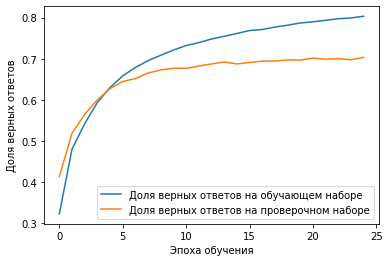

In [48]:
plt.plot(graph_history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(graph_history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [49]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Доля верных ответов на тестовых данных составляет:',round(scores[1]* 100, 4),'%')

1034/1034 [==============================] - 9s 9ms/step - loss: 1.3055 - accuracy: 0.7030
Доля верных ответов на тестовых данных составляет: 70.2978 %


# Сохранить/загрузить модель нейронной сети

Сохранение нейронной сети на Google Drive

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [36]:
model.save('gdrive/My Drive/models/function_name_prediction/{name}/maxlen{len}_e{epochs}_p{precent}.h5'.format(
    name=model_name,
    len=maxlen,
    epochs=len(graph_history['accuracy']),
    precent=int(graph_history['val_accuracy'][-1]*1000)
))

Сохранение нейронной сети в дерикторию

In [50]:
model.save('{name}_maxlen{len}_e{epochs}_p{precent}.h5'.format(
    name=model_name,
    len=maxlen,
    epochs=len(graph_history['accuracy']),
    precent=int(graph_history['val_accuracy'][-1]*1000)
))

Загрузка модели нейронной сети из файла

In [ ]:
MODEL_PATH = ''
model = load_model(MODEL_PATH)